In [1]:
# !pip install datasets
# !pip install transformers

In [2]:
%env TORCH_USE_CUDA_DSA=1
%env CUDA_LAUNCH_BLOCKING=1

env: TORCH_USE_CUDA_DSA=1
env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Iterate over each GPU and display its specifications
    for gpu_id in range(num_gpus):
        print(f"\nGPU {gpu_id} specifications:")
        
        # Set the current device
        torch.cuda.set_device(gpu_id)
        
        # Get the device properties
        device_properties = torch.cuda.get_device_properties(gpu_id)
        
        # Display the device name
        print(f"Device name: {device_properties.name}")
        
        # Display the total memory
        total_memory = device_properties.total_memory / (1024 * 1024)  # Convert bytes to MB
        print(f"Total memory: {total_memory:.2f} MB")
        
        # Display the major and minor compute capability
        major, minor = device_properties.major, device_properties.minor
        print(f"Compute capability: {major}.{minor}")
        
        # Display the number of multiprocessors
        num_multiprocessors = device_properties.multi_processor_count
        print(f"Number of multiprocessors: {num_multiprocessors}")
        
      
else:
    print("CUDA is not available. Please check your PyTorch installation and GPU setup.")

Number of available GPUs: 1

GPU 0 specifications:
Device name: NVIDIA A100-SXM4-80GB MIG 7g.80gb
Total memory: 81050.62 MB
Compute capability: 8.0
Number of multiprocessors: 98


In [4]:
from datasets import load_dataset
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset("beans")

# Load the pre-trained model and feature extractor
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)


/home/tuchsanai/.conda/envs/torch/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

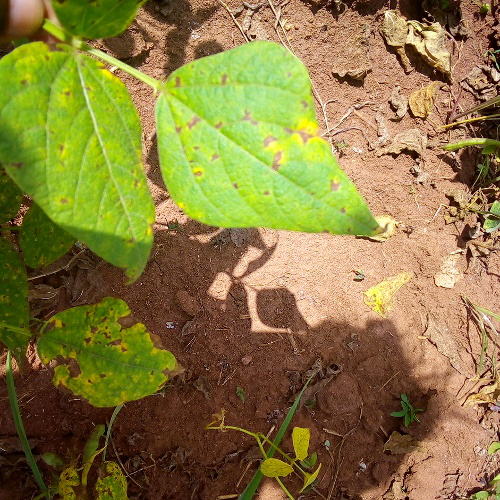

In [6]:
dataset['train'][0]['image']

In [7]:

# Define the image augmentation transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Preprocess the dataset with image augmentation
def preprocess_function(examples):
    inputs = {}
    inputs["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    inputs["labels"] = examples["labels"]
    return inputs

def preprocess_function_val(examples):
    inputs = {}
    inputs["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    inputs["labels"] = examples["labels"]
    return inputs

processed_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
processed_dataset["validation"] = dataset["validation"].map(preprocess_function_val, batched=True, remove_columns=dataset["validation"].column_names)

# Display

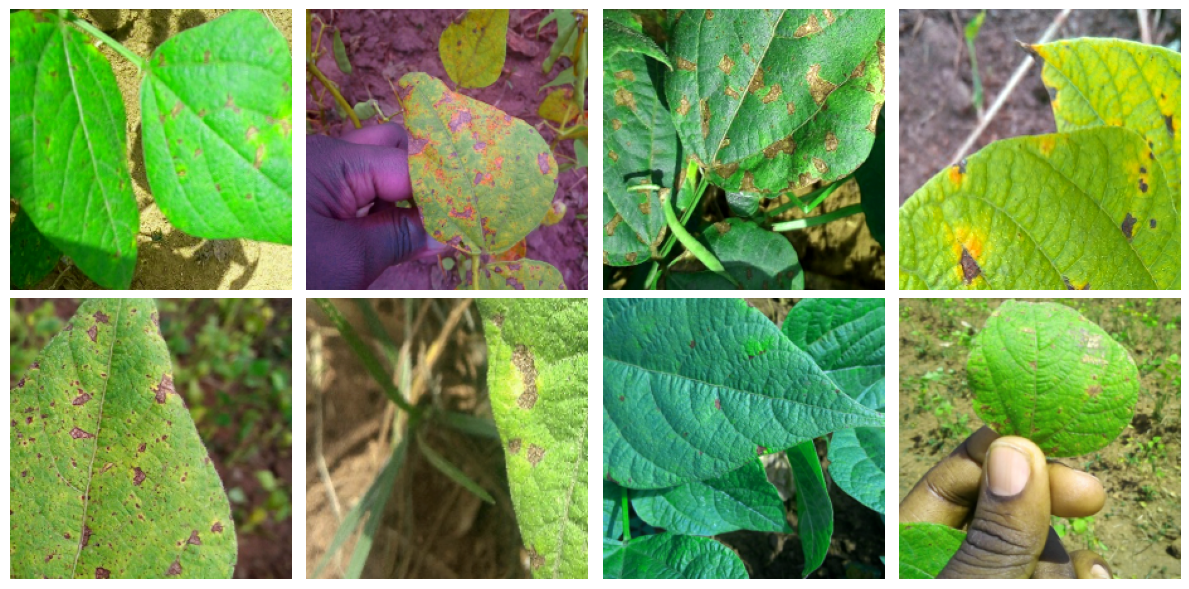

In [8]:
# Display some augmented images
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(2):
    for j in range(4):
        image = processed_dataset["train"][i*4+j]["pixel_values"]
        image = torch.tensor(image)  # Convert the list to a tensor
        image = image.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())  # Normalize pixel values to [0, 1]
        axs[i, j].imshow(image)
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()

In [9]:

# Define the data collator
def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    evaluation_strategy="steps",
    num_train_epochs=5,
    #fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=False,
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=feature_extractor,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

/home/tuchsanai/.conda/envs/torch/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [8,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [9,0,0] Assertion `t 

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
